# LVM Data Simulator tutorial: create your own source field

**This tutorial is focused mainly on how to simulate the nebular components as an input for the LVM Data Simulator.**

We consider here three examples. One is for very simplified nebulae (useful if you don't worry about the gas kinematics and variations of the line ratios). Second example describes the more complicated case and consider the usage of the various models and varying kinematics. Third example is showing how to simulate the nebula having the realistic brightness distribution (e.g., extracted from observations, or from in-details simulations).
- The main steps on how to install, configure and run the code are considered in the [tutorial #1](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial1.ipynb).
- More details on the setup of LVM instrumentation and interpretation of the outputs of the lvmdatasimulator are given in [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb)
- If you want to use the simulator as an ETC, please refer to [tutorial #4](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial4.ipynb)
- If you are interested in producing Raw LVM data (as input for DRP) - please go to [tutorial #5](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial5.ipynb) describing 2D simulator



_Last update: 2022/09/01_

## Prepare everything

We assume you have *lvmdatasimulator* properly installed and configured. See the first tutorial for details.

In [31]:
# === Don't forget to set up your work directory. By default, this is your current directory unless you are running the simulation on the UTAH cluster.
import os

import numpy as np

# os.chdir('/Users/mors/Science/LVM/Simulator_example/')


In [10]:
# === Import everything related to lvmdatasimulator and other libraries used in this tutorial
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

import astropy.units as u
from astropy.io import fits
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch, LinearStretch
from matplotlib import pyplot as plt

We will not change the instrumentation setup in this tutorial, so can initialize the necessary components here at once

In [11]:
tel = LVM160()
spec = LinearSpectrograph()
# we moderately limit the number of fibers to speed up the calculations.
bundle = FiberBundle(bundle_name='full', nrings=8)

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 8 hexagonal rings.



## Example 1: Simulate simple nebulae

In this example we simulate a nebulae with constant line profile and line ratios. These simulations will run fast, but physically the models are not meaningful.  

**Such simplified case might be useful as an alternative to the ETC.**

### Step 1: Initialize field of view

We should set up the important parameters of your observations. Namely:
- RA and Dec of the center of FOV
- Size of your FOV in arcminutes (**Note: you can use any other angular units, if necessary**) *[default = 35 arcmin]*
- Size of the pixel in arcseconds *[default = 1 arcsec]*

Also there are several optional parameters defining properties of the ISM. These values will be used for each nebula in your ISM unless you provide them separately for a particular nebula:
- Distance (to calculate the conversion from pixels and arcseconds to physical scale and vice versa) *[default = 50 kpc]*
- Systemic velocity *[default = 0 km/s]* (**Note: Systemic velocity only affect emission lines, not the continuum**)
- Turbulent velocity dispersion (used to broaden the line profile) *[default = 20 km/s]*
- Preserve_kinematics *[default = False]* - this flag is used to indicate whether you worry about gas kinematics in this simulation. If yes - the initial line profiles will be better sampled, but the cost is the longer computational time

Also, we define the units used for the spatial coordinates. There is no needs to provide the units for other parameters (but they can be explicitly defined)

*You have to initialize __LVMField__ before adding any stars or nebulae to your model.*

In [12]:
ra = 12.34 # u.degree
dec = -20.35 # u.degree
fov_size = 30 # u.arcmin
fov_pixel = 1 # u.arcsec
distance = 50 # * u.kpc
sys_vel = 0 #* u.km / u.s
turbulent_sigma = 20 #* u.km / u.s
preserve_kinematics = False

unit_ra = u.degree
unit_dec = u.degree
unit_size = u.arcmin
unit_pixel = u.arcsec

Define your field of view, initialize telescope, spectrograph and observations properties.

**Note:** name of the LVMField is important - all your intermediate and output files will be stored in the corresponding folder with the same name

In [13]:
name = 'LVM_simple_example'
my_lvmfield = LVMField(ra=ra, dec=dec, size=fov_size, pxsize=fov_pixel, name=name,
                       unit_ra=unit_ra, unit_dec=unit_dec, unit_size=unit_size, unit_pxsize=unit_pixel,
                       ism_params={'distance': distance, 'sys_velocity': sys_vel, 'turbulent_sigma': turbulent_sigma,
                                   'preserve_kinematics': preserve_kinematics})

**Note:** there is no needs to provide most of parameters if you use default values. I.e. You can get the same __LVMField__ as above by doing:



In [14]:
my_lvmfield = LVMField(ra, dec, fov_size, fov_pixel, name=name)

### Step 2. Add ISM and stars to your model
Our simple example will consist of the following components:
- Stars fetched from GAIA catalogue
- Diffuse ionized gas (DIG) filling the whole FOV.
- Background early-type galaxy with Sersic profile and no emission lines
- Three emission-line nebulae of different simple shape: Ellipse, Rectangle and Filament. Filament will also emit in continuum.
- Dark absorbing nebula defined as a Circle

#### Add stars (from GAIA and user-defined)
First, we add stars brighter than 15mag to our LVMField from the GAIA catalogue

In [15]:
my_lvmfield.generate_gaia_stars(gmag_limit=15)

[INFO]: 525 Gaia stars in the field
[INFO]: 500 stars are fainter than 15 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...


INFO: Query finished. [astroquery.utils.tap.core]


[INFO]: Rescaling 25 synthetic spectra.
[INFO]: Saving star list to: ./LVM_simple_example/LVM_simple_example_starlist.fits.gz


We can also add stars manually providing their parameters (RA, Dec, g-magnitude, effective temperature, extinction in g filter, LOS velocity).
Stellar spectra from with the closest parameters the templates will be attached to the stars.

**N.B. In the current version this will overwrite the previously fetched stars. This will be fixed soon**

In [8]:
my_additional_stars = {'ra': [12.33, 12.31, 12.30], 'dec': [-20.34, -20.37, -20.40], 'gmag': [12, 15, 17],
                       'teff': [30000, 35000, 40000], 'ag': [0.04, 0.05, 0.06], 'v': [50, 70, 90]}

my_lvmfield.generate_single_stars(parameters=my_additional_stars)

[INFO]: star 26 with Teff 30000, Gmag 12 and velocity 50 added at position (12.33 , -20.34)
[INFO]: star 27 with Teff 35000, Gmag 15 and velocity 70 added at position (12.31 , -20.37)
[INFO]: star 28 with Teff 40000, Gmag 17 and velocity 90 added at position (12.3 , -20.4)
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
100% (28 of 28) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
[INFO]: Rescaling 28 synthetic spectra.


Let's take a look to what we already have in our FOV:

[WARNING]: Bundle center coords are not defined, using the coords of the field.


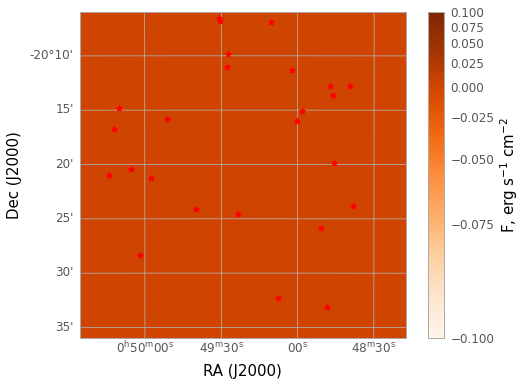

In [16]:
my_lvmfield.show()

Now, it is time to generate the nebulae to our FOV. First, we want to add DIG component which will fill whole FOV.
We will produce also correlated inhomogeneities in its brightness distribution defined by relative amplitude and spatial scale. You can set these parameters to zero if you want to see a homogeneous distribution.

**For every nebulae ``max_brightness`` corresponds to the H $\alpha$ surface brightness in the brightest part of the nebula.** By default, it is in $erg/s/cm^2/arcsec^2$, but can be expressed in the equivalent units (in that case the values should be multiplied to the corresponding astropy.units). All other parameters requiring the units (distance, sizes, scales, angles, velocities etc.) also can be defined as numbers or with explicitly mentioned astropy.units.

#### Diffuse ionized gas

In [17]:
dig = {"type": 'DIG', 'max_brightness': 2e-16, 'perturb_amplitude': 0.1, 'perturb_scale': 500 * u.pc}

In [18]:
my_lvmfield.add_nebulae(dig)

[INFO]: Start generating 1 nebulae
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_366'


Now let's see what we get after adding DIG. Note that you can choose colormap and percentile interval to display the image.
Also, we use the parameter ``fibers`` to overlay the localization of the fibers bundle (defined above during the preparation)

[WARNING]: Bundle center coords are not defined, using the coords of the field.


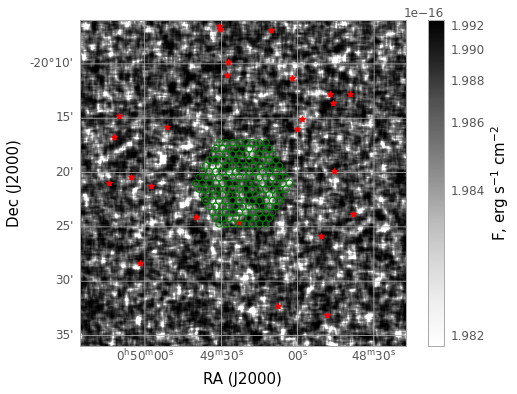

In [19]:
my_lvmfield.show(cmap=plt.cm.Greys, percentile=96, fibers=bundle.fibers_science)

#### Positioning the nebulae

Let's add now another two nebulae, but this time simultaneously, as a list of dictionaries. One of them will be ``Rectangle``, the other ``Ellipse``. Both these nebulae will have uniform distribution of the surface brightness and constant line ratios.

In contrast with DIG, these nebulae have limited size, and thus we need to define their position in the FOV. This can be done in several ways:
- providing parameters `X` and `Y` (or `RA` and `DEC`), which define the position of the central pixel in the FOV (in pixels or in RA-DEC)
- providing offsets along X and Y axes (or along RA and DEC). Offsets along X and Y should be in pixels, while along RA and DEC in arcsec (or any other angular units). Note that positive value of `offset_RA` will shift the nebula to the left (towards the higher RA).

When you use several nebulae in the FOV, you may want to define in which order they are located along the line of sight. This is useful if you want to simulate the situation when there is a dark cloud on the line of sight that is absorbing part of the light from the background nebulae (and produce the reddening of the spectra). This can be done with the parameter ``zorder``. By default, this is equal to -1 for ``DIG`` and to 0 for all other nebulae. Lower value means that the object is further along the line of sight from the observer.

By default, the method ``add_nebulae`` will overwrite the ISM content that has been early attached to the FOV. To avoid this, don't forget to use the parameter ``overwrite=False``.


In [20]:
my_nebulae = [{'type': 'Rectangle', 'offset_RA': 120.*u.arcsec, 'offset_DEC': -50.*u.arcsec, 'width': 90 * u.pc, 
               'height': 60 * u.pc, 'max_brightness': 7e-16, 'zorder': 2},
              {'type': 'Ellipse', 'offset_X': -150, 'offset_Y': 300, 'ax_ratio': 0.5, 'PA': 20, 'radius': 100 * u.pc, 
               'distance': 150 * u.kpc, 'max_brightness': 1e-15},
              ]
my_lvmfield.add_nebulae(my_nebulae, overwrite=False)

[INFO]: Start generating 2 nebulae
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_366'
[WARNING]: No model ids or model parameters are set for the nebula #1: use default cloudy 'model_id=Cloud_366'


Note the warning saying that the default cloudy model is used to produce the nebula. We will be back to this in the second example.

In this example, we set up a different ``distance`` to the ``Ellipse`` nebula from what we used for the ISM. That is why the physical pixel scale for this nebula is different and thus it has smaller angular size on the image even despite its larger physical size.

[WARNING]: Bundle center coords are not defined, using the coords of the field.


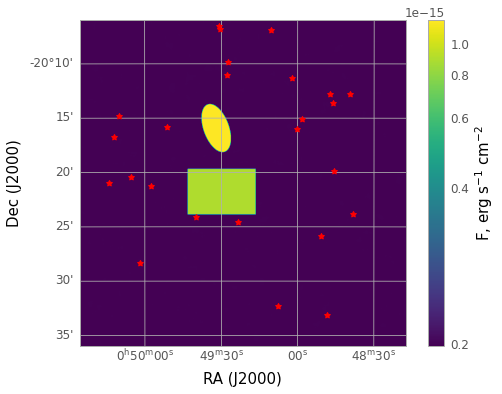

In [21]:
my_lvmfield.show(cmap=plt.cm.viridis, percentile=99)

The offsets of each nebulae in FOV can be easily adjusted. Here ``nebula_id`` starts from 0 and corresponds to the number of the nebula as it was added to FOV, ``offset`` is along X and Y, and units can be either angular or pixels (default). Let's shift the ``Ellipse``

[WARNING]: Bundle center coords are not defined, using the coords of the field.


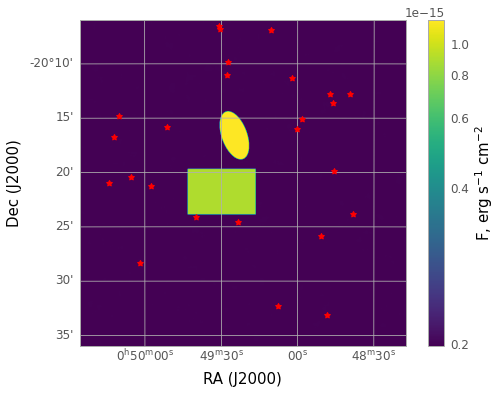

In [22]:
my_lvmfield.shift_nebula(nebula_id=2, offset=(100., -40.), units=(u.arcsec, u.arcsec))
my_lvmfield.show(cmap=plt.cm.viridis, percentile=99)

#### Nebulae with continuum and extinction

Let's add three more nebulae. Now we want to generate the object with non-uniform distribution of the brightness. For example, ``Galaxy``, whose brightness is defined using a Sersic profile, and a long and thin ``Filament`` representing a cylinder. Also both objects will emit in the continuum, and the ``Galaxy`` object will not emit any emission lines (``max_brighness = 0`` or not defined).

The continuum shape can be set up in four ways:
- ``continuum_type = 'BB'``: SED corresponds to the black-body with $T_eff$ equal to the parameter ``continuum_data``.
- ``continuum_type = 'poly'``: SED is defined as polynomial with coefficients in ``continuum_data``.
- ``continuum_type = 'model``:
    - if ``continuum_data`` is a dictionary having keys ``wl`` and ``flux`` (numpy arrays or lists), then these values define the continuum that will be interpolated to the regular wavelenght grid.
    - if ``continuum_data`` is an int number, then it corresponds to the ID of the pre-defined Starburst99 model.

Flux normalization of the continuum is defined in the following way. Either ``continuum_mag`` or ``continuum_flux`` should be provided. In the first case ``continuum_wl`` should be equal to one of the allowed filters (B, V, R, I, sdss_g, sdss_r, sdss_i). Then the ``continuum_mag`` corresponds to the magnitude in that filter. If ``continuum_flux`` is provided, then it is assumed to be the flux density at the wavelength defined in ``continuum_wl`` (in Angstrom)

The third object is a dark ``Circle`` that doesn't emit anything, but contains absorbing dust that is defined by the ``max_extinction`` property (corresponds to $A_V$ in magnitudes)

**Note: every nebula can be either dark or emitting. But any of them can have continuum.**

In [16]:
my_nebulae = [ {'type': 'Galaxy', 'offset_X': 220, 'offset_Y': -250, 'distance': 10*u.Mpc,
               'r_eff': 10 * u.kpc, 'rad_lim': 5., 'n': 1.5, 'ax_ratio': 0.7, 'PA': 35 * u.degree, 'vel_rot': 90,
               'continuum_type': 'model', 'continuum_data': 3, 'continuum_mag': 22*u.mag/u.arcsec**2, 'continuum_wl': 'V'},
              {'type': 'Filament', 'offset_RA': -105., 'offset_DEC': 160.,
               'length': 100 * u.pc, 'width': 8*u.pc, 'PA': -65 * u.degree,
               'max_brightness': 3e-16, 'continuum_type': 'BB', 'continuum_data': 35000, 'continuum_flux': 1e-16, 'continuum_wl': 5500},
               {'type': 'Circle', 'offset_RA': -4., 'offset_DEC': 15.,
               'radius': 40 * u.pc, 'max_extinction': 2 * u.mag},
              ]
my_lvmfield.add_nebulae(my_nebulae, overwrite=False)

[INFO]: Start generating 3 nebulae
 33% (1 of 3) |########                  | Elapsed Time: 0:00:02 ETA:   0:00:04[WARNING]: No model ids or model parameters are set for the nebula #1: use default cloudy 'model_id=Cloud_366'
100% (3 of 3) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


[WARNING]: Bundle center coords are not defined, using the coords of the field.


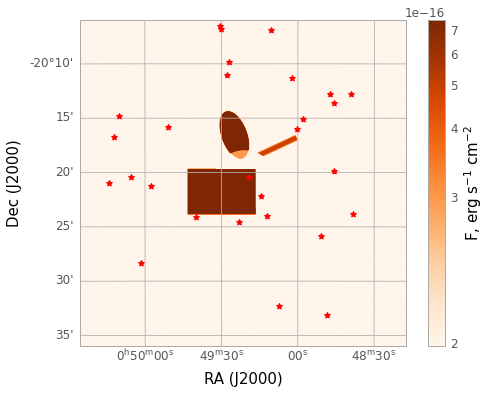

In [17]:
my_lvmfield.show(percentile=95)

One may notice few things on the top image:
- The ``Ellipse`` is extincted, but the ``Rectangle`` is not. This is because of the mentioned earlier parameter ``zorder``. All nebulae are sorted according to that, and only those nebulae with ``zorder`` less than ``zorder`` for the dark cloud are processed. Since the ``Rectangle`` has ``zorder=2``, it is assumed to be located closer to us along the line of sight, and thus the extinction does not affect it.
- **Note that extinction doesn't affect the stars in this version of the code. Also, at the moment there is some bug in the code, and zorder works incorrectly for saving the fits-files with the images. The latter will be fixed soon**
- ``Galaxy`` is not visible! This is because by default the displayed image is the pure Halpha line, and this Galaxy has no associated emission spectrum. To see it, we can first produce a new map - using a broader wavelength range. It will be also automatically saved as fits-file in your work directory.

[INFO]: Input image in 6560.0-6565.0AA wavelength range is saved to LVM_simple_example_6560_6565_input_map.fits
[WARNING]: Bundle center coords are not defined, using the coords of the field.


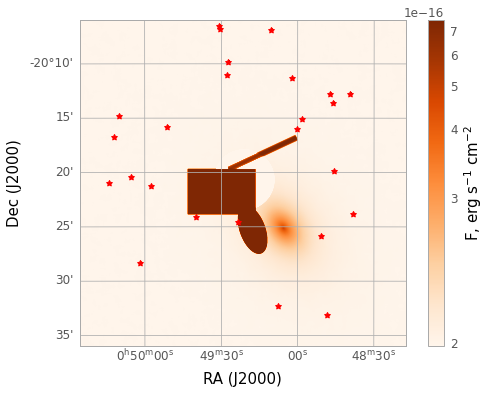

In [34]:
my_lvmfield.get_map(wavelength_ranges=[6560, 6565])
my_lvmfield.show(percentile=95)

Note: you can check the available ID of the SB99 models as follows:

In [19]:
from lvmdatasimulator.utils import models_grid_summary
tab = models_grid_summary('continuum')
tab.pprint_all()

 ID     Name                                     Description                                  
--- ----------- ------------------------------------------------------------------------------
  0   Z0.040_t1   Starburst99: Z=0.040, age=1Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  1   Z0.040_t2   Starburst99: Z=0.040, age=2Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  2   Z0.040_t3   Starburst99: Z=0.040, age=3Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  3   Z0.040_t4   Starburst99: Z=0.040, age=4Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  4   Z0.040_t5   Starburst99: Z=0.040, age=5Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  5   Z0.040_t6   Starburst99: Z=0.040, age=6Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  6   Z0.040_t7   Starburst99: Z=0.040, age=7Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  7   Z0.040_t8   Starburst99: Z=0.040, age=8Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  8   Z0.040_t9   Starburst99: Z=0.040, age=9Myr, 

#### Selecting a different nebular spectrum

So far, we did not provide the simulator any information on the properties of the emission-line spectrum associated to each nebula. Therefore, a default spectrum is used when creating the nebulae. However, the simulator is shipped with spectral libraries that can be used to simulate more realistic nebulae, and, in principle, any user provided library can be used, as long it is provided in the correct format. 

Two different libraries are provided with the package, in the `data` directory:
- A library based on custom [Cloudy](https://trac.nublado.org/) photoionization simulations of H II regions.
- The complete set of MAPPINGS models from the [Allen et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJS..178...20A/abstract) recovered from the [3mdB](http://3mdb.astro.unam.mx:3686/) database.

The structure of this file is quite specific and will be described in details in a dedicated section of the documentation. However, it might be important to know few things:
- Each extension corresponds to particular set of the parameters of the nebula and ionizing source. The `Cloudy` library includes both the integrated version of the spectrum of the nebula, as well as its radially resolved one. The Allen's models only contain the integrated version of the spectra, since the resolved version is not provided by the 3mdb database.
- The integrated spectra are used for all nebulae by default, except for ``Cloud`` and ``Bubble`` **when selecting a Cloudy model**. When selecting one of Allen's models, also ``Cloud`` and ``Bubble`` uses the integrated spectra. If one needs to generate one of these objects with the constant line ratio and Cloudy models, they can add the key ``linerat_constant = True`` to the dictionary describing the nebula.
- There are two types of **Cloudy** models - roughly, produced for shells and clouds. Latter assume that the nebulae have inner radius close to zero, while $R_{in}=10 pc$ was assumed to produce the shell-like geometry models. We recommend to use them for ``Bubble`` nebulae, while those with the cloud geometry are fine for all other nebulae. The radial distribution of the line fluxes in the simulator is produced as follows:
    - The whole radial extent of the nebula is normalized to the range [0,1], where 0 corresponds to the inner wall (or to the center, if it is a ``Cloud``), and 1 - to the outer edge.
    - Same is also performed for the radial extent of the selected Cloudy model
    - Then the Cloudy model is interpolated to the radial extend of the nebulae according to these calculated relative normalized positions
- There are three types of Allen's models. One contains the ``shock`` spectra, the second contains the ``precursor`` spectra, and the final one contains both.
- The line list for the two libraries is slightly different, with the MAPPINGS library containing less lines since some of the lines included in the Cloudy models do not have a match in the 3mdb version of the Allen's models. 

To select the desired model for your nebulae one can provide either the parameter ``model_id`` (equal to the ``Model_ID`` column in the summary table), or the dictionary ``model_params``, containing the information about the desired parameters of the model, in combination with the parameter ``model_type`` (which must be ``cloudy`` for Cloudy models, and ``mappings`` for Allen's models). If ``model_params`` is used, the model closed to the provided parameters will be selected.

A default choice for both the Cloudy and Allen's models is provided in the [configuration file](https://github.com/sdss/lvmdatasimulator/blob/7ffbaa4bcd7506d82e45a0e1bf6aa9416460c74c/python/lvmdatasimulator/etc/lvmdatasimulator.yml)

It is possible to save your own grid of Cloudy models in the same format as used in the lvmdatasimulator. To do this, there is a function ``save_cloudy_models`` in the ``utils.py``. The same can be done for MAPPINGS models, but no utility function is provided yet.

To get the summary of the available models we provide an utility function as follows. The parameters that should be provided via the ``model_params`` dictionary are the ones included in these tables.

In [20]:
from lvmdatasimulator.utils import models_grid_summary
cloudy = models_grid_summary('cloudy')
cloudy

Model_ID,Geometry,Z,qH,LogLsun,Teff,nH,Rin,Rout,Nzones,Nlines,Distance,Flux_Ha,Source_model
str10,str5,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str43
Shell_1,Shell,0.8,50.3,6.5,50000.0,500.0,10.01,10.09,119,141,50.0,9.528778703652963e-10,LVM_Cloudy_z0.80_l6.5_t50000_n500.0_r10.0
Cloud_1,Cloud,1.0,49.7,6.0,40000.0,500.0,0.01,1.67,230,141,50.0,2.425748569407134e-10,LVM_Cloudy_z1.00_l6.0_t40000_n500.0_r0.0
Cloud_2,Cloud,0.8,49.8,6.0,120000.0,100.0,0.01,6.25,320,141,50.0,3.1211451946697835e-10,LVM_Cloudy_z0.80_l6.0_t120000_n100.0_r0.0
Shell_2,Shell,0.2,48.4,4.5,60000.0,100.0,10.01,10.08,123,141,50.0,1.0449082651998981e-11,LVM_Cloudy_z0.20_l4.5_t60000_n100.0_r10.0
Cloud_3,Cloud,0.6,48.7,5.5,25000.0,30.0,0.01,5.1,240,141,50.0,2.500678347117836e-11,LVM_Cloudy_z0.60_l5.5_t25000_n30.0_r0.0
Cloud_4,Cloud,0.4,48.1,4.5,35000.0,100.0,0.01,1.54,228,141,50.0,6.021576630112747e-12,LVM_Cloudy_z0.40_l4.5_t35000_n100.0_r0.0
Cloud_5,Cloud,0.6,51.0,7.5,30000.0,100.0,0.01,13.14,296,141,50.0,4.359351204470388e-09,LVM_Cloudy_z0.60_l7.5_t30000_n100.0_r0.0
Cloud_6,Cloud,0.4,50.2,6.5,40000.0,100.0,0.01,7.7,281,141,50.0,7.483808065868175e-10,LVM_Cloudy_z0.40_l6.5_t40000_n100.0_r0.0
Cloud_7,Cloud,1.0,51.3,7.5,50000.0,100.0,0.01,16.8,311,141,50.0,9.79130036450541e-09,LVM_Cloudy_z1.00_l7.5_t50000_n100.0_r0.0


In [21]:
mappings = models_grid_summary('mappings')
mappings

Model_ID,model_type,AbundID,preshck_dens,preshck_temp,mag_fld,shck_vel,Nzones,Nlines,Flux_Ha
str25,str20,int64,float64,float64,float64,float64,float64,float64,float64
Shock_1,shock,1,1.0,14107.0,0.0001,100.0,1.0,107.0,2.3349934720000002e-05
Shock_2,shock,1,1.0,21011.0,0.0001,475.0,1.0,107.0,0.00073478966
Shock_3,shock,1,1.0,14507.0,10.0,200.0,1.0,107.0,8.296584589999999e-05
Shock_4,shock,1,1.0,28954.0,0.0001,850.0,1.0,107.0,0.002271118084
Shock_5,shock,1,1.0,30510.0,2.0,925.0,1.0,107.0,0.00397989218
Shock_6,shock,1,1.0,15683.0,5.0,225.0,1.0,107.0,0.00012205494399999999
Shock_7,shock,1,1.0,29201.0,4.0,875.0,1.0,107.0,0.0036519816
Shock_8,shock,1,1.0,27769.0,0.5,800.0,1.0,107.0,0.002515780785
Shock_9,shock,1,1.0,26545.0,3.23,750.0,1.0,107.0,0.002434548393


We are now ready to start selecting the emission-line spectra assocuated to the nebulae. Since the FOV is already rather crowded, instead of adding new nebulae we will start from scratch and redefine them in the same way. However, the rectangular filament will be associated to shock models, while the elliptical nebulae will be associated to a Cloudy model.

In [23]:
my_lvmfield = LVMField(ra, dec, fov_size, fov_pixel, name='LVM_simple_example')

my_lvmfield.generate_gaia_stars(gmag_limit=15)

my_additional_stars = {'ra': [12.33, 12.31, 12.30], 'dec': [-20.34, -20.37, -20.40], 'gmag': [12, 15, 17],
                       'teff': [30000, 35000, 40000], 'ag': [0.04, 0.05, 0.06], 'v': [50, 70, 90]}

my_lvmfield.generate_single_stars(parameters=my_additional_stars)

dig = {"type": 'DIG', 'max_brightness': 2e-16, 'perturb_amplitude': 0.1, 'perturb_scale': 500 * u.pc}
rect = {'type': 'Rectangle', 'offset_RA': 120.*u.arcsec, 'offset_DEC': -50.*u.arcsec, 'width': 90 * u.pc, 
        'height': 60 * u.pc, 'max_brightness': 7e-16, 'zorder': 2}
galaxy = {'type': 'Galaxy', 'offset_X': 220, 'offset_Y': -250, 'distance': 10*u.Mpc,
          'r_eff': 10 * u.kpc, 'rad_lim': 5., 'n': 1.5, 'ax_ratio': 0.7, 'PA': 35 * u.degree, 'vel_rot': 90,
          'continuum_type': 'model', 'continuum_data': 3, 'continuum_mag': 22*u.mag/u.arcsec**2, 'continuum_wl': 'V'}
dark = {'type': 'Circle', 'offset_RA': -4., 'offset_DEC': 15., 'radius': 40 * u.pc, 
        'max_extinction': 2 * u.mag}

[INFO]: 525 Gaia stars in the field
[INFO]: 500 stars are fainter than 15 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...


INFO: Query finished. [astroquery.utils.tap.core]


[INFO]: Rescaling 25 synthetic spectra.
[INFO]: Saving star list to: ./LVM_simple_example/LVM_simple_example_starlist.fits.gz
[WARNING]: The file ././LVM_simple_example/LVM_simple_example_starlist.fits.gz already exist and it will be overwritten


[INFO]: star 26 with Teff 30000, Gmag 12 and velocity 50 added at position (12.33 , -20.34)
[INFO]: star 27 with Teff 35000, Gmag 15 and velocity 70 added at position (12.31 , -20.37)
[INFO]: star 28 with Teff 40000, Gmag 17 and velocity 90 added at position (12.3 , -20.4)
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
[INFO]: Rescaling 28 synthetic spectra.


Let's first define the filament. We are interested in a pure shock model, with relatively low velocity (300 km/s), SMC metallicity (AbundID=1), a preshock density of 1, a preshock temperature of around 15000K and a magnetic field of 0.4 muG. We can input the parameters as a dictionary as shown below, and the code will look for the model which is closer to the input parameters. We have to define the ``model_type`` keyword, so that the simulator know we are looking for Allen's models

In [24]:
filament =  {'type': 'Filament', 'offset_RA': -105., 'offset_DEC': 160., 
             'length': 100 * u.pc, 'width': 8*u.pc, 'PA': -65 * u.degree,
             'max_brightness': 3e-16, 'continuum_type': 'BB', 'continuum_data': 35000, 
             'continuum_flux': 1e-16, 'continuum_wl': 5500,
             'model_params': {'model_type': 'shock', 'AbundID': 1, 'preshck_dens': 1, 'preshck_temp': 1.5e4,
                              'mag_fld': 0.4, 'shck_vel': 300},
             'model_type': 'mappings'}

For the ``Ellipse`` we go for a Cloudy model with a Cloud geometry, a metallicity of 0.4, a number of ionizing photons of 50.2, a stellar luminosity of 6.5 L_sun and a T of 40000.0 and finally a density of 100.0 atoms/cm-3. We can input the informations as we did before:

In [25]:
ellipse = {'type': 'Ellipse', 'offset_X': 50., 'offset_Y': -260., 'ax_ratio': 0.5, 'PA': 20, 
           'radius': 100 * u.pc, 'distance': 150 * u.kpc, 'max_brightness': 1e-15,
           'model_params': {'Geometry': 'Cloud', 'Z': 0.4, 'qH': 50.2, 'LogLsun': 6.5,
                            'Teff': 4e4, 'nH': 100},
           'model_type': 'cloudy'}

Now we can finally join all these nebulae in a list, and add them to the LVMField object.

In [26]:
nebulae = [dig, rect, galaxy, dark, filament, ellipse]

my_lvmfield.add_nebulae(nebulae)

[INFO]: Start generating 6 nebulae
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_366'
[WARNING]: No model ids or model parameters are set for the nebula #1: use default cloudy 'model_id=Cloud_366'
[WARNING]: Use the closest pre-computed model with id = Shock_221


#### Save ISM content
The produced ISM content can be saved to a fits file. We will describe soon (in README) how the nebular content is organized in this file

In [27]:
my_lvmfield.save_ism("testneb_tutorial3_ex1.fits")

[INFO]: Generated ISM saved to ./LVM_simple_example/testneb_tutorial3_ex1.fits
[INFO]: ISM content saved to testneb_tutorial3_ex1.fits


### Step 3. Run simulations
If needed, you can load previously saved region to process it further with simulator. Don't forget to load the stars as well!

In [28]:
my_lvmfield.add_nebulae(load_from_file="testneb_tutorial3_ex1.fits")
my_lvmfield.open_starlist('LVM_simple_example_starlist.fits.gz')

[INFO]: Nebulae successfully loaded from file


Now it is time to "observe" our sources. Necessary instrumental setup is already initialized, the only remaining part is ``Observation``
For that, we should define exposure time (or several exposure times, in seconds) and the same RA and DEC that were used to create source field.
**N.B.: in the current version we simulate only single exposures (not combined)**.
Then we initialize the ``Simulator`` which combines all components

In [29]:
exptimes = [900, 10 * 900] # in seconds
obs = Observation(ra=ra, dec=dec, unit_ra=u.deg, unit_dec=u.deg, exptimes=exptimes)
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)

Everything is ready now. Let's go!
The simulator will extract the spectra in each fiber from each nebula (and stars), add sky and readout noise. It takes longer for more extended nebulae (e.g. DIG), or if the nebula has varying LSF or line fluxes (see Example 2). In our example, the spectra extraction and interpolation to the instrument wavelength grid should last in about 1 minute (on laptop)

In [30]:
sim.simulate_observations()
sim.save_outputs()

[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /Users/mors/Science/PyWorkspace/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 169 fibers.
[INFO]: Start extracting nebular spectra
[INFO]: Resampling spectra to the instrument wavelength solution.
[INFO]: Saving the outputs:
[INFO]: Input spectra
[INFO]: ./LVM_simple_example/outputs/LVM_simple_example_linear_full_input.fits saved.
[INFO]: Clean outputs
[INFO]: ./LVM_simple_example/outputs/LVM_simple_example_linear_full_900_no_noise.fits saved.
[INFO]: ./LVM_simple_example/outputs/LVM_simple_example_linear_full_9000_no_noise.fits saved.
[INFO]: Uncalibrated outputs
[INFO]: ./LVM_simple_example/outputs/LVM_simple_example_linear_full_900_realization.fits

The resulting spectra for each exposure time are available now in the working directory. The content of the files is described in details in tutorial [tutorial #2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb). But let's briefly see how this looks like

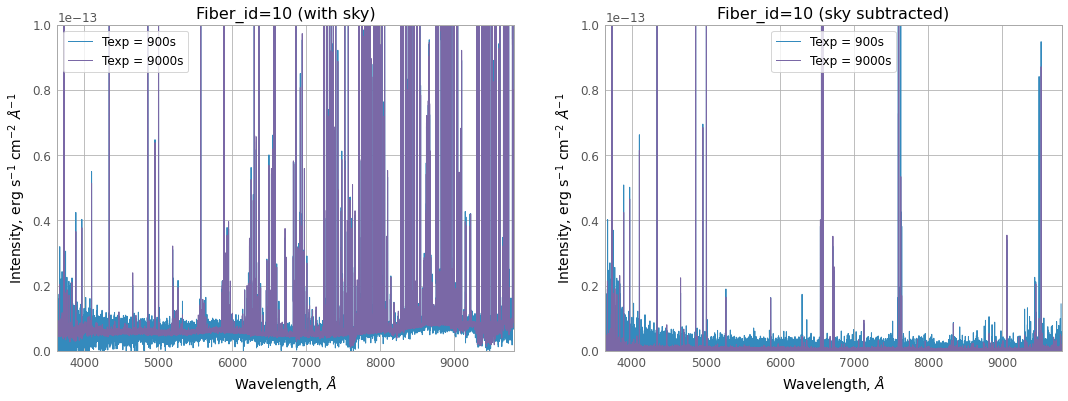

In [32]:
fig = plt.figure(figsize=(18,6))
fiber_id = 10
with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[0]}_flux.fits") as hdu:
    wave = hdu['Wave'].data
    flux_short_exp = hdu['TOTAL'].data[fiber_id]
    flux_short_exp_nosky = hdu['TARGET'].data[fiber_id]
with fits.open(f"{name}/outputs/{name}_linear_full_{exptimes[1]}_flux.fits") as hdu:
    flux_large_exp = hdu['TOTAL'].data[fiber_id]
    flux_large_exp_nosky = hdu['TARGET'].data[fiber_id]
ax = plt.subplot(121)
plt.plot(wave, flux_short_exp, linewidth=1, label=f"Texp = {exptimes[0]}s")
plt.plot(wave, flux_large_exp, linewidth=1, label=f'Texp = {exptimes[1]}s')
plt.legend()
plt.xlabel("Wavelength, $\AA$",fontsize=14)
plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
plt.ylim(0,1e-13)
plt.xlim(3640,9810)
plt.title(f"Fiber_id={fiber_id} (with sky)", fontsize=16)

ax = plt.subplot(122)
plt.plot(wave, flux_short_exp_nosky, linewidth=1, label=f"Texp = {exptimes[0]}s")
plt.plot(wave, flux_large_exp_nosky, linewidth=1, label=f'Texp = {exptimes[1]}s')
plt.legend()
plt.xlabel("Wavelength, $\AA$",fontsize=14)
plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
plt.ylim(0,1e-13)
plt.xlim(3640,9810)
plt.title(f"Fiber_id={fiber_id} (sky subtracted)", fontsize=16);

Now we want to save also the resulting map and to compare it with the input map.

In [33]:
sim.save_output_maps(wavelength_ranges=[6560, 6565])

[INFO]: Saving the 2D output maps
[INFO]:  Saving ./LVM_simple_example/outputs/LVM_simple_example_linear_full_6560_6565_900s_target_map.fits...
[INFO]:  Saving ./LVM_simple_example/outputs/LVM_simple_example_linear_full_6560_6565_900s_total_map.fits...
[INFO]:  Saving ./LVM_simple_example/outputs/LVM_simple_example_linear_full_6560_6565_9000s_target_map.fits...
[INFO]:  Saving ./LVM_simple_example/outputs/LVM_simple_example_linear_full_6560_6565_9000s_total_map.fits...
[INFO]:  Saving ./LVM_simple_example/outputs/LVM_simple_example_fibers.reg...


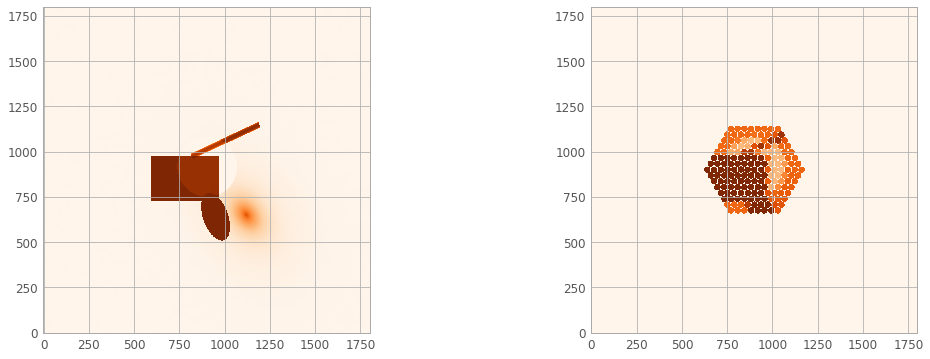

In [35]:
fig = plt.figure(figsize=(18,6))
ax=plt.subplot(121)
with fits.open(f"{name}/{name}_6560_6565_input_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data, stretch=AsinhStretch(), interval=PercentileInterval(96.))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)
ax=plt.subplot(122)
with fits.open(f"{name}/outputs/{name}_linear_full_6560_6565_{exptimes[1]}s_total_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data, stretch=AsinhStretch(), interval=PercentileInterval(96.))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)

## Example 2: Simulation of nebulae with varying line ratios and kinematics
In this example we will consider more complex types of the nebulae. Currently, only ``Cloud`` and ``Bubble`` allow for varying line ratios as a function of the position in the nebulae (namely, radial variations) and only when using the Cloudy models. The main difference between them is that ``Cloud`` is a filled sphere, while ``Bubble`` has a limited thickness (defined by parameter ``thickness`` [default=0.2]).

Let's create now a new LVMField using these more complex nebulae. Also, since now we want to trace the gas kinematics, it might be useful to set parameter ``preserve_kinematics = True``. **However, at the moment we will continue to use ``preserve_kinematics = False`` since otherwise it will significantly slow down computations of the ``Bubbles``. We will work on the improvements. If you don't simulate ``Bubbles`` or ``Clouds`` - use ``preserve_kinematics = True``.**

Also we mention the usage of ``vel_amplitude`` keyword which defines the range of possible velocities relative to systemic velocity for all nebulae. By default, ``vel_amplitude = 150 *u.km/u/s``. **In this version of the code it is very important to make sure this value exceeds the possible range of the relative velocities in the line profiles of the nebulae (including the broadening, which is defined by ``turbulent_sigma``). Otherwise there will be problems during the spectra extraction**

In [33]:
name = 'LVM_simple_example'
my_lvmfield = LVMField(ra=ra, dec=dec, size=fov_size, pxsize=fov_pixel, name=name,
                       ism_params={'preserve_kinematics': False, 'vel_amplitude': 150.})

We start with adding the DIG. This time we want to use a specific model, i.e. a some moderate luminosity source of ionization with low temperature, low density and metallicity equal to Z=0.6Zsun. Looking at the table above, we find that ``Model_ID = 'Cloud_3'`` pass these criteria.

Also, we may want to limit the number of the lines to use in the output. By default, simulator use 141 emission lines (depends on the pre-defined Cloudy models grid). Providing the keyword ``n_brightest_lines = 20`` will limit the spectra to 20 brightest lines. This might be very helpful to speed up the calculations if the fainter lines are not important.

In [34]:
dig = {"type": 'DIG', 'max_brightness': 2e-16, 'perturb_amplitude': 0.1, 'perturb_scale': 500 * u.pc,
       'n_brightest_lines': 20, 'model_id': 'Cloud_3', 'model_type': 'cloudy'}
my_lvmfield.add_nebulae(dig)

[INFO]: Start generating 1 nebulae
100% (1 of 1) |##########################| Elapsed Time: 0:00:03 Time:  0:00:03


Now we'll add the Bubble. Let's assume this is ionized by a source having $L=10^5L_\odot$ and $T_{eff}=65000 K$, the density is $n_H = 150 cm^{-3}$ and the metallicity is solar (note also that we will use the ``Sphere`` geometry). There is no such Cloudy model in our grid, but the code will select one with the closest parameters.

We also assume that this bubble has a ``sys_velocity = -50 * u.km/u.s`` and it is expanding with ``expansion_velocity = 30 * u.km/u.s``.

**N.B. To simulate bubbles and clouds, we first compute their parameters in a 4D grid, which makes the calculations very memory (RAM) intensive. We are looking on a way to simplify this, but, for now. please avoid adding big bubbles/clouds to your source field. For example, simulations of the Bubble with $R>25-30$ pc (at the default distance 50 kpc => angular size is a key here) might be painful if you want to do this on a laptop.**

As the computation of bubbles might be expensive, we want to save the result right after it's ready. If you are unhappy with the further components, you can load this file and start the simulation from them.

[INFO]: Start generating 1 nebulae
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[WARNING]: Use the closest pre-computed model with id = Shell_349
100% (1 of 1) |##########################| Elapsed Time: 0:01:37 Time:  0:01:37
[INFO]: Generated ISM saved to ./testneb_tutorial2_ex2.fits
[INFO]: ISM content saved to testneb_tutorial2_ex2.fits
[WARNING]: Bundle center coords are not defined, using the coords of the field.


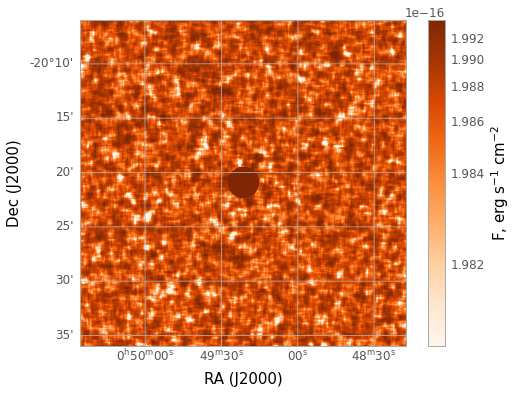

In [35]:
bubble = {'type': 'Bubble', 'max_brightness': 8e-16, 'thickness': 0.2, 'radius': 20, 'expansion_velocity': 30, 'sys_velocity': -50,
          'n_brightest_lines': 20, 'model_params': {'Z': 1., 'Teff': 65000, 'LogLsun': 5., 'nH': 150, 'Geometry': 'Shell'},
          'model_type': 'cloudy', 'offset_RA':0, 'offset_DEC':0}
my_lvmfield.add_nebulae(bubble, overwrite=False, save_nebulae='testneb_tutorial2_ex2.fits')
my_lvmfield.show(percentile=98)

Now we will add one background ``Galaxy`` with systemic velocity ``sys_velocity = 2000 u.km/u.s`` and rotating with the velocity ``vel_rot = 50*u.km/u.s``.
Also there will be one filament with the velocity gradient along it (you can set up it for any nebula except ``Bubble`` and ``Cloud`` using the parameter ``vel_gradient`` in units of km/s/pc). Also we make the line profile of the ``Filament`` slightly more broadened than in other nebulae (e.g. because of the shocks).
In both cases, by default the position angle of the kinematic axis is the same as for the object. However, it can be changed using ``vel_pa``.

In [36]:
my_lvmfield.add_nebulae(load_from_file='testneb_tutorial2_ex2.fits')

my_nebulae = [{'type': 'Galaxy', 'offset_RA': -180., 'offset_DEC': 180., 'distance': 15*u.Mpc,
               'r_eff': 10 * u.kpc, 'rad_lim': 5., 'n': 1.5, 'ax_ratio': 0.7, 'PA': 35 * u.degree,
               'max_brightness': 6e-16,'continuum_type': 'model', 'continuum_data': 60, 
               'continuum_mag': 22*u.mag/u.arcsec**2, 'continuum_wl': 'R',
               'sys_velocity': 2000, 'vel_rot': 40},
              {'type': 'Filament', 'offset_RA': 70., 'offset_DEC': -280., 'length': 200*u.pc, 
               'width': 5 * u.pc, 'PA': -60, 'max_brightness': 1e-15,
               'turbulent_sigma': 40, 'vel_gradient': 0.7, 'vel_pa': -60}
              ]
my_lvmfield.add_nebulae(my_nebulae, overwrite=False)

[INFO]: Nebulae successfully loaded from file
[INFO]: Start generating 2 nebulae
  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[WARNING]: the expected velocities are larger than 'vel_amplitude', there might be some problems with the outputs.
[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_366'
 50% (1 of 2) |#############             | Elapsed Time: 0:00:06 ETA:   0:00:06[WARNING]: No model ids or model parameters are set for the nebula #1: use default cloudy 'model_id=Cloud_366'
100% (2 of 2) |##########################| Elapsed Time: 0:00:09 Time:  0:00:09


[WARNING]: Bundle center coords are not defined, using the coords of the field.


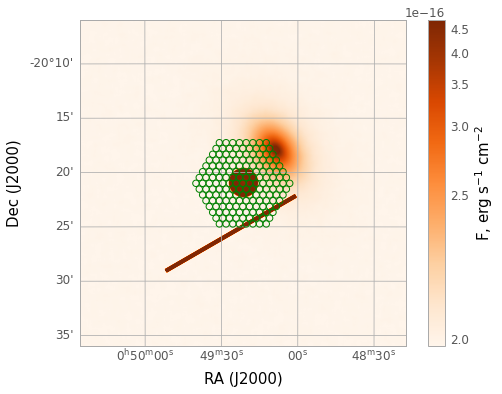

In [37]:
my_lvmfield.show(fibers=bundle.fibers_science)

Now, once we are satisfied with the position of the other components, we want to overwrite the existing file and start the simulator

In [38]:
my_lvmfield.save_ism('testneb_tutorial2_ex2.fits')
my_lvmfield.get_map(wavelength_ranges=[6550, 6570])

[INFO]: Generated ISM saved to ./testneb_tutorial2_ex2.fits
[INFO]: ISM content saved to testneb_tutorial2_ex2.fits
[INFO]: Input image in 6550.0-6570.0AA wavelength range is saved to LVM_simple_example_6550_6570_input_map.fits


In [39]:
obs = Observation(ra=ra, dec=dec, exptimes=[900, 10*900])
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(wavelength_ranges=[6550, 6570])

[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /mnt/DATA/LVM/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 169 fibers.
[INFO]: Start extracting nebular spectra
100% (4 of 4) |##########################| Elapsed Time: 0:03:13 Time:  0:03:13
[INFO]: Resampling spectra to the instrument wavelength solution.
[INFO]: Saving the outputs:
[INFO]: Input spectra
[INFO]: ./outputs/LVM_simple_example_linear_full_input.fits saved.
[INFO]: Clean outputs
[INFO]: ./outputs/LVM_simple_example_linear_full_900_no_noise.fits saved.
[INFO]: ./outputs/LVM_simple_example_linear_full_9000_no_noise.fits saved.
[INFO]: Uncalibrated outputs
[INFO]: ./outputs/LVM_simple_example_linear_full_900_realization.fits saved.
[INFO]

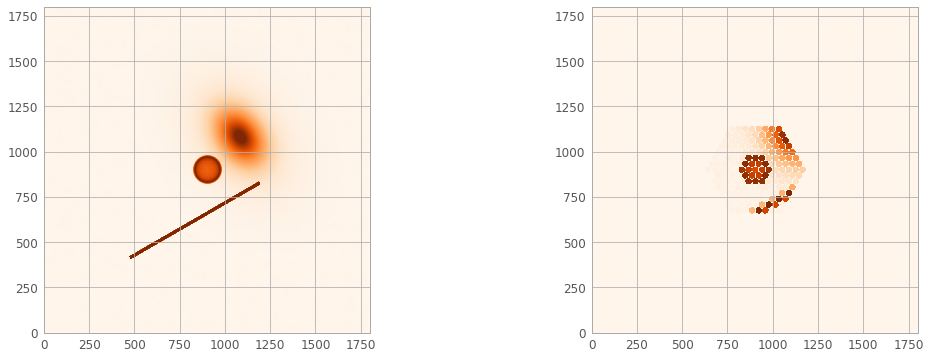

In [40]:
fig = plt.figure(figsize=(18,6))
ax=plt.subplot(121)
with fits.open(f"{name}/{name}_6550_6570_input_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data, stretch=AsinhStretch(), interval=PercentileInterval(99.))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)
ax=plt.subplot(122)
with fits.open(f"{name}/outputs/{name}_linear_full_6550_6570_9000s_total_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data[hdu[0].data > 0], stretch=AsinhStretch(), interval=PercentileInterval(99))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)

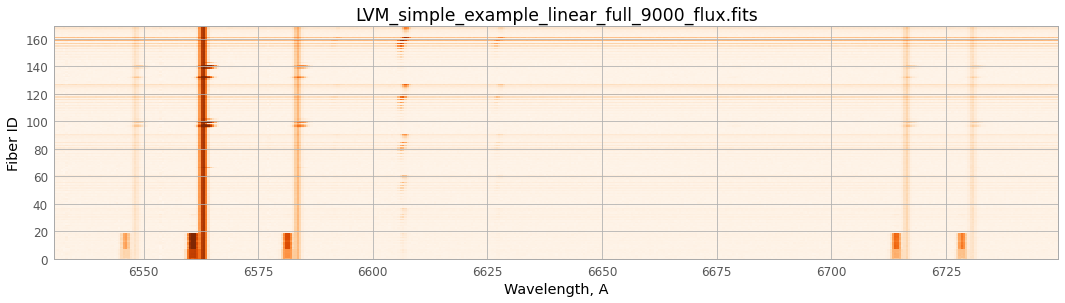

In [41]:
fig = plt.figure(figsize=(18,6))
ax=plt.subplot(111)
filename = 'LVM_simple_example_linear_full_9000_flux.fits'
with fits.open(f"{name}/outputs/{filename}") as hdu:
    wave = hdu['WAVE'].data
    select_wl = (wave > 6530) & (wave < 6750)
    norm = ImageNormalize(hdu['TARGET'].data[:, select_wl], stretch=AsinhStretch(), interval=PercentileInterval(99.9))
    ax.imshow(hdu['TARGET'].data[:, select_wl], origin='lower', interpolation='nearest', cmap=plt.cm.Oranges,
              norm=norm, extent=(wave[select_wl][0], wave[select_wl][-1], 0, hdu['TARGET'].data.shape[0]), aspect=0.3)
    ax.set_xlabel('Wavelength, A')
    ax.set_ylabel('Fiber ID')
    ax.set_title(filename)

As you can see, the velocity of the filament (illuminating several fibers) is indeed not uniform, and the line profile is broadened.
The velocity offset for bubble is also observed, as well as two-component line profile in its center (fibers ID ~0). However, such small expansion velocity results in rather broadening of the line profile than into its splitting onto the components - spectral and (in this case - more importantly) angular resolution is insufficient.
And the galaxy is definitely red-shifted and rotating.

## Example 3: Realistic nebulae.

Here we will consider how to run simulations of nebulae with a realistic brightness distribution. For example, what if you want to simulate the LVM data for the particular nebula for which you have one or more emission line images? Or maybe you want to see how a more realistic simulated nebula (e.g., with WARPFIELD) will look like when observed by LVM?

There is a class ``CustomNebula`` that allows one to simulate such objects.

In this tutorial, we will simulate the data for a supernova remnant (SNR) in the Large Magellanic Cloud: N186D. We will use the images from MCELS ([Smith et al. 2005 ](https://ui.adsabs.harvard.edu/abs/2005AAS...207.2507S/abstract)) as a base for the simulation.

First, download the cutout of this region in Halpha, [SII] and [OIII] lines (note: absolute calibration here is arbitrary) to the working directory:

``wget ftp@ftp.das.uchile.cl:/pub/enrico/N186D_maps.fits``

Next, we read the flux maps in these lines. Also, we assume Hbeta = Ha/2.86, [O III]4959A = [O III]5007A/3, [S II]6717/6731 = 1.4, [N II]6583A = 0.1 Halpha,  [N II]6548A = [N II]6583A/3.
Size of the pixel in these maps is equal to 2 arcsec - we will need this later.

In [42]:
pxsize = 2 * u.arcsec
with fits.open("N186D_maps.fits") as hdu:
    ha = hdu['Ha'].data
    s2_sum = hdu['SII'].data
    o3_5007 = hdu['OIII'].data

# Save all in a single dictionary with keys equal to wavelength in angstroms
obs_data = {6562.81: ha, 4861.: ha/2.86, 5007.: o3_5007, 4959.: o3_5007/3., 6548.: ha*0.1/3, 6584.: ha*0.1, 6717.: s2_sum/2.4, 6731.: s2_sum/2.4/1.4}

As usual, we first create a new FOV.

Then we add three nebulae to the FOV.
- DIG component
- Nebula with the user-defined brightness distribution in all mentioned above emission lines
- Similar nebula, but this time we set up only Halpha brightness and make it two times smaller.

To define ``CustomNebula``, we have to provide one necessary parameter: ``brightness_map``. ``brightness_lines`` should be also present if you want to simulate the realistic flux distribution in different lines. ``pxsize`` should be present if the size of the pixels in your maps is different from that in the FOV.

- ``brightness_map`` should be numpy.array containing the brightness distribution in Halpha line.
- ``brightness_lines`` is a dictionary like ``obs_data`` defined above. Its keys should be equal to exact rest-frames wavelength that will be added to the output spectrum. The values are numpy.arrays of the same size as ``brightness_map`` and contain the flux distribution in the corresponding lines.
- ``pxsize`` is the size of the pixel in the numpy array. By default, this is in parsecs and it assumes a distance of 50 kpc (unless a different distance is defined for the specific nebula). It is also possible to use angular quantities (e.g., u.arcsec) which will be converted to pc using the default or a user-provided distance. If omitted - then it is assumed to be equal to the pixel size of the FOV component (converted to parsecs). 

**Important notes:**
- both  ``brightness_map`` and values of ``brightness_lines`` should be in absolute units (in the current version of the code - strictly in erg/s/cm\^2/arcsec^2)
- if ``brightness_lines`` is absent or empty, then the emission spectrum will be generated based on the selected or default Cloudy models, as it is for other nebulae. Line ratios will be considered as not varying across the nebula.
- if ``brightness_lines`` is present and not empty, then **only** those lines defined in this dictionary will be in the output spectrum for this particular nebula.
- ``max_brightness`` doesn't work for ``CustomNebula`` (as this value is defined based on the provided ``brightness_map``)

Class ``CustomNebula`` produce the nebulae in the same way as ``Rectangle``, but with the user-defined brightness distribution. It means that in principle, it is possible to add, e.g., velocity gradients or any other properties to the generated nebula.


In [43]:
name = 'LVM_customneb_example'
my_lvmfield = LVMField(ra, dec, fov_size, fov_pixel, name=name)

my_nebulae = [
        {"type": 'DIG', 'max_brightness': 1e-16 * u.erg / u.cm ** 2 / u.s / u.arcsec ** 2,
        'perturb_amplitude': 0.1, 'perturb_scale': 200 * u.pc},
        {"type": 'CustomNebula', 'brightness_map': ha, 'model_id': 'Cloud_4', 'model_type': 'cloudy',
         'offset_RA': -150, 'offset_DEC':-100, 'pxsize': pxsize},  # here the size is in angular units
        {"type": 'CustomNebula', 'brightness_map': ha, 'brightness_lines':obs_data,
         'offset_RA': 320, 'offset_DEC': 130}  # using the default pixsize --> smaller nebula!
]
my_lvmfield.add_nebulae(my_nebulae, save_nebulae="LVM_customneb_ISM.fits", overwrite=True)

[INFO]: Start generating 3 nebulae
  0% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[WARNING]: No model ids or model parameters are set for the nebula #0: use default cloudy 'model_id=Cloud_366'
100% (3 of 3) |##########################| Elapsed Time: 0:00:11 Time:  0:00:11
[INFO]: Generated ISM saved to ./LVM_customneb_ISM.fits
[INFO]: ISM content saved to LVM_customneb_ISM.fits


Now we can display the Halpha image with the overlayed full LVM fibers array

[INFO]: Using the full hexagon pattern
[INFO]: Input image in 6550.0-6570.0AA wavelength range is saved to LVM_customneb_example_6550_6570_input_map.fits
[WARNING]: Bundle center coords are not defined, using the coords of the field.


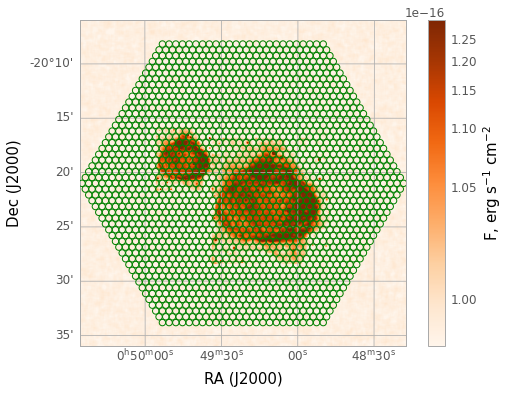

In [44]:
bundle = FiberBundle(bundle_name='full')
my_lvmfield.get_map(wavelength_ranges=[6550, 6570])
my_lvmfield.show(fibers=bundle.fibers_science, outname='custom_neb_full.png')

To speed up the calculations for this example, we are limiting the spectra extraction to only 16 of 24 fibers rings.
**However, even this will be time demanding and can take more than 30 minutes**. If you want to get the result faster - you can adjust ``FiberBundle`` below and set up smaller number of ``nrings``. Or you may want to remove the DIG component - this will speed up the calculations for the full array by ~20 min.

In [45]:
bundle = FiberBundle(bundle_name='full', nrings=16)
exptimes = [900, 10 * 900] # in seconds
obs = Observation(ra=ra, dec=dec, exptimes=exptimes)
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(wavelength_ranges=[6550, 6570])

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 16 hexagonal rings.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /mnt/DATA/LVM/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 721 fibers.
[INFO]: Start extracting nebular spectra
  0% (0 of 3) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[INFO]: Dividing the array in 4 with an overlap of 40.7 arcsec
 33% (1 of 3) |########                  | Elapsed Time: 0:04:07 ETA:   0:08:15[INFO]: Dividing the array in 4 with an overlap of 40.7 arcsec
100% (3 of 3) |##########################| Elapsed Time: 0:08:29 Time:  0:08:29
[INFO]: Resampling spect

Compare the input and output images (in Halpha line)

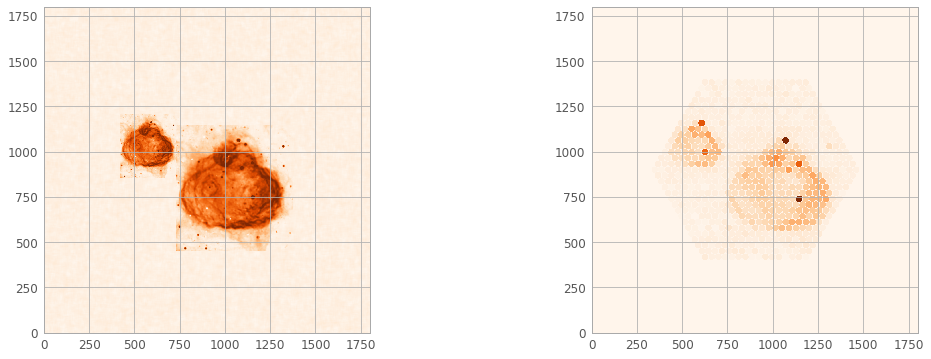

In [46]:
fig = plt.figure(figsize=(18,6))
ax=plt.subplot(121)
with fits.open(f"{name}/{name}_6550_6570_input_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data, stretch=AsinhStretch(), interval=PercentileInterval(99.6))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)
ax=plt.subplot(122)
with fits.open(f"{name}/outputs/{name}_linear_full_6550_6570_9000s_total_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data[hdu[0].data > 0], stretch=AsinhStretch(), interval=PercentileInterval(99.5))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)

Now we want to do another test - compare the lines fluxes ratios [SII]/Ha and [OIII]/Hb in input and output data. We have already images in Halpha, now we save them in other lines.

In [47]:
sim.save_output_maps(wavelength_ranges=([6715, 6732], [5000, 5010], [4855, 4865]))
my_lvmfield.get_map(wavelength_ranges=([6715, 6732], [5000, 5010], [4855, 4865]))

[INFO]: Saving the 2D output maps
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_6715_6732_900s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_6715_6732_900s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_6715_6732_9000s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_6715_6732_9000s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_5000_5010_900s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_5000_5010_900s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_5000_5010_9000s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_5000_5010_9000s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_4855_4865_900s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_customneb_example_linear_full_4855_4865_900s_total_map.fits...
[INFO]:  Saving ./outputs/L

[WARNING]: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first. (MatplotlibDeprecationWarning)
[WARNING]: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first. (MatplotlibDeprecationWarning)


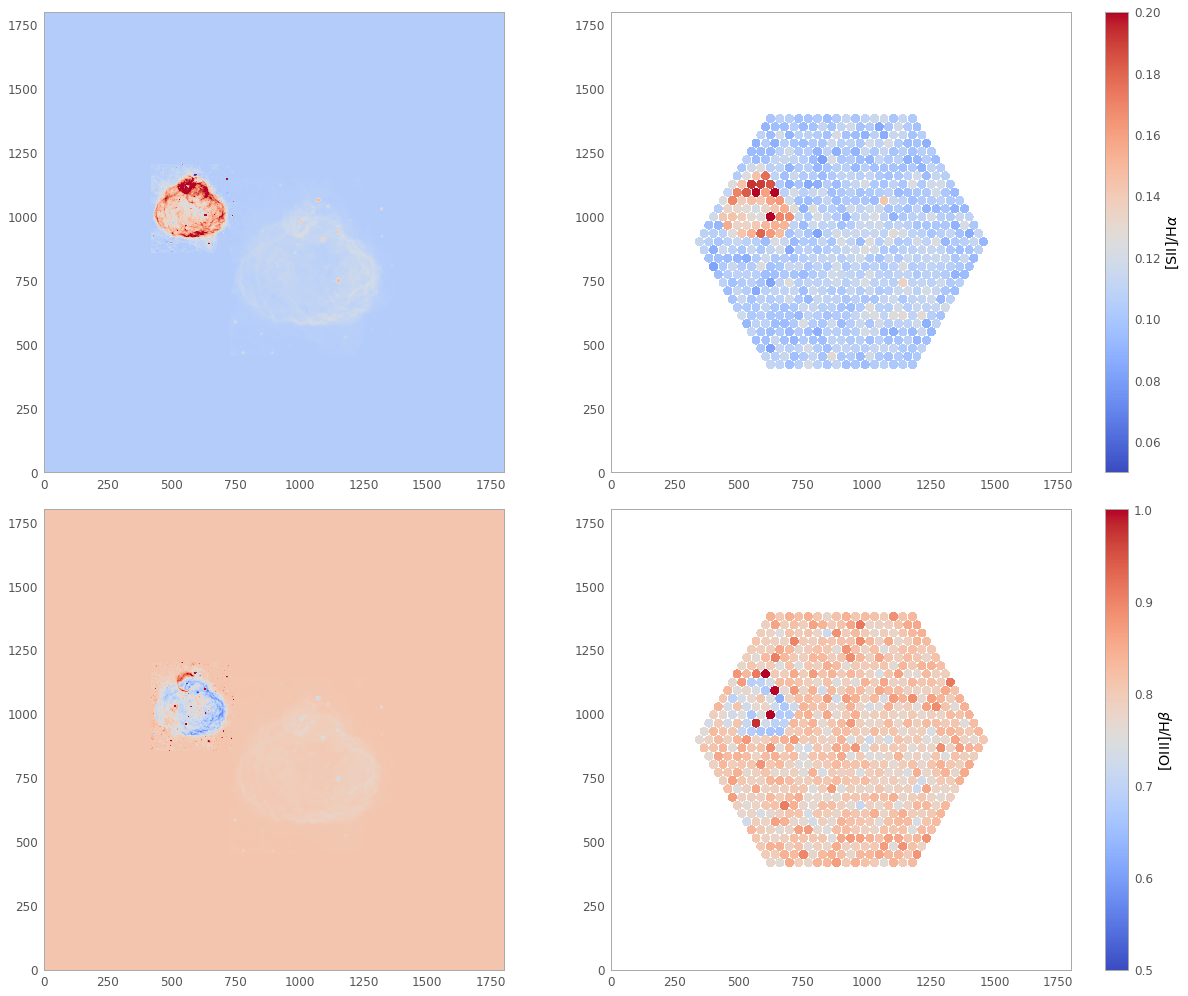

In [48]:
fig = plt.figure(figsize=(18, 14))
with fits.open(f"{name}_6550_6570_input_map.fits") as hdu:
    ha_input = hdu[0].data
with fits.open(f"{name}_6715_6732_input_map.fits") as hdu:
    s2_input = hdu[0].data
with fits.open(f"{name}_5000_5010_input_map.fits") as hdu:
    o3_input = hdu[0].data
with fits.open(f"{name}_4855_4865_input_map.fits") as hdu:
    hb_input = hdu[0].data

with fits.open(f"{name}/outputs/{name}_linear_full_6550_6570_9000s_target_map.fits") as hdu:
    ha_out = hdu[0].data
with fits.open(f"{name}/outputs/{name}_linear_full_6715_6732_9000s_target_map.fits") as hdu:
    s2_out = hdu[0].data
with fits.open(f"{name}/outputs/{name}_linear_full_5000_5010_9000s_target_map.fits") as hdu:
    o3_out = hdu[0].data
with fits.open(f"{name}/outputs/{name}_linear_full_4855_4865_9000s_target_map.fits") as hdu:
    hb_out = hdu[0].data

ax=plt.subplot(221)
plt.grid(False)
img = ax.imshow((s2_input/ha_input), origin='lower', interpolation='nearest', cmap=plt.cm.coolwarm, vmin=0.05, vmax=0.2)

ax=plt.subplot(222)
plt.grid(False)
img = ax.imshow((s2_out/ha_out), origin='lower', interpolation='nearest', cmap=plt.cm.coolwarm, vmin=0.05, vmax=0.2)
cb = plt.colorbar(img)
cb.set_label(r'[SII]/H$\alpha$')

ax=plt.subplot(223)
plt.grid(False)
img = ax.imshow((o3_input/hb_input), origin='lower', interpolation='nearest', cmap=plt.cm.coolwarm, vmin=0.5, vmax=1.)

ax=plt.subplot(224)
plt.grid(False)
img = ax.imshow((o3_out/hb_out), origin='lower', interpolation='nearest', cmap=plt.cm.coolwarm, vmin=.5, vmax=1.)
cb = plt.colorbar(img)
cb.set_label(r'[OIII]/H$\beta$')
plt.tight_layout()
fig.savefig("test_flux_ratios.png", dpi=300, bbox_inches='tight')

We set up the line ratio for the nebula #1 (large copy of N186D) to be constant, and user-defined fluxes in the emission lines were provided for nebula #2 (small copy of N186D). That is why the latter is significantly different from the DIG and nebula #1. Note that the lines fluxes ratio for the nebula #1 are not constant in the maps above - this is because of the contribution of the DIG with the slightly different line ratios (and perturbations in the brightness), and due to the noise (instrumental + Poisson) on the output images.